<a href="https://colab.research.google.com/github/caherman13/BMIS-331-Final-Project/blob/main/Python_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd

#Importing CSV files into workbook

#Filtering columns to be imported from the objects file
columns_to_import = ['id', 'entity_type', 'entity_id', 'name', 'normalized_name', 'category_code', 'status', 'description', 'overview', 'tag_list', 'country_code', 'state_code', 'city']

#establishing datatypes in objects columns
data_types = {
    'category_code': str,
    'description': str,
    'country_code': str,
    'state_code': str ,
    'city': str,
}

#importing csv files
investments = pd.read_csv("investments.csv")
objects = pd.read_csv("objects.csv", usecols=columns_to_import, dtype=data_types)
funds = pd.read_csv("funds.csv")
funding_rounds = pd.read_csv("funding_rounds.csv")
ipos = pd.read_csv("ipos.csv")
acquisitions = pd.read_csv("acquisitions.csv")

In [ ]:
#merging investments and funds to match fund id to its investments
funds_investments_unfiltered = pd.merge(investments, funds, left_on='investor_object_id', right_on='object_id', how='inner')

funds_investments = funds_investments_unfiltered[['funding_round_id', 'funded_object_id', 'name', 'funded_at']].rename(columns={'name': 'Fund_name'})


In [ ]:
#merging funds investments with the company through objects csv
investments_investor_unfiltered = pd.merge(funds_investments, objects, left_on = 'funded_object_id', right_on = 'id', how='inner')

investments_investor = investments_investor_unfiltered[['funding_round_id', 'funded_object_id', 'entity_type', 'Fund_name', 'funded_at', 'name', 'category_code','status', 'description','overview','tag_list',
                                                        'country_code', 'state_code', 'city']].rename(columns={'name': 'Invested_Company_name'})
#showing only companies
investments_investor = investments_investor[investments_investor['entity_type'] == 'Company']


In [ ]:
#merging investments w/ investment round to show valuation
investments_info_unfiltered = pd.merge(investments_investor, funding_rounds, left_on = 'funding_round_id', right_on = 'funding_round_id', how='inner')

investments_info = investments_info_unfiltered[['funding_round_id', 'funded_object_id', 'Fund_name', 'Invested_Company_name', 'category_code','status', 'description','overview','tag_list',
                                                        'country_code', 'state_code', 'city', 'raised_amount_usd', 'pre_money_valuation_usd', 'post_money_valuation_usd']].rename(columns={'pre_money_valuation_usd': 'pre_money_valuation', 'post_money_valuation_usd': 'post_money_valuation'})

#establishing what categories I want to filter companies by
filtered_values = ['hardware', 'ecommerce', 'network_hosting', 'web', 'software', 'semiconductor', 'mobile', 'biotech', 'cleantech', 'nanotech']

investments_info = investments_info[investments_info['category_code'].isin(filtered_values)]

#company had a value post investment
investments_info = investments_info[investments_info['post_money_valuation'] > 0]


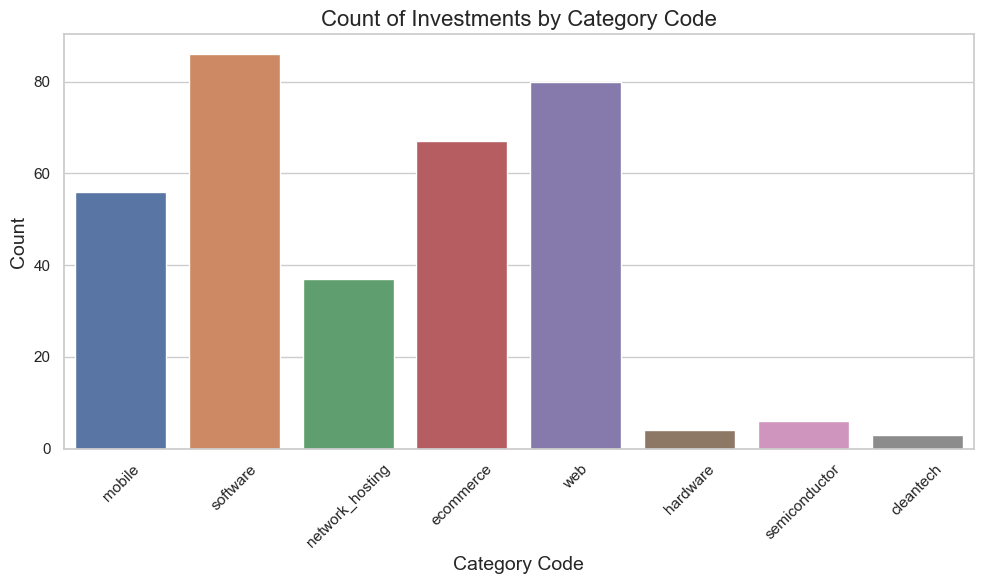

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjusting the width of the bars
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Creating the count plot
sns.countplot(data=investments_info, x="category_code")

# Customizing the labels
plt.xlabel('Category Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Investments by Category Code', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the figure
plt.savefig('category_investment_count.png')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()


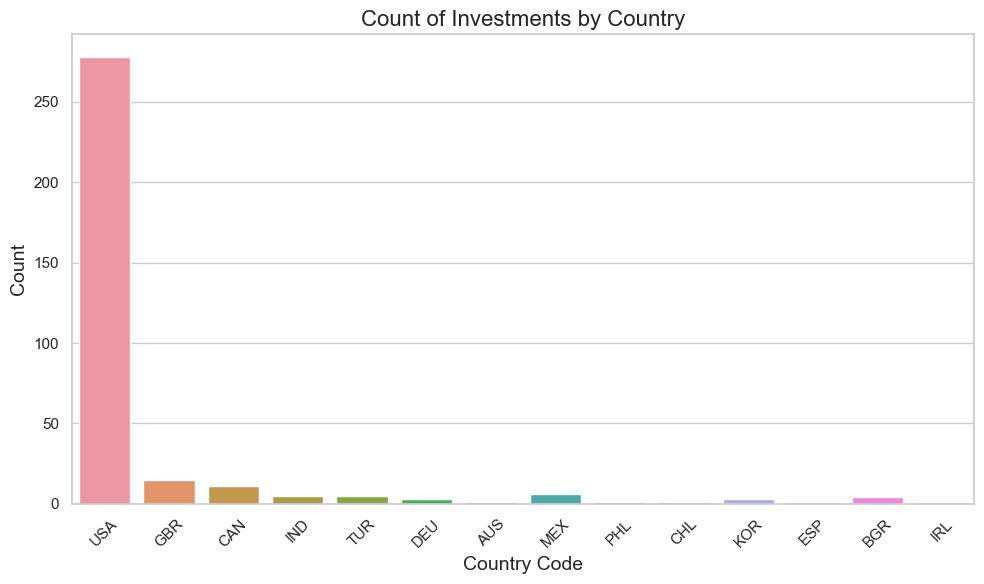

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Adjusting the width of the bars
sns.set(style="whitegrid")
plt.figure(figsize=(10, 6))

# Creating the count plot
sns.countplot(data=investments_info, x="country_code")

# Customizing the labels
plt.xlabel('Country Code', fontsize=14)
plt.ylabel('Count', fontsize=14)
plt.title('Count of Investments by Country', fontsize=16)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Save the figure
plt.savefig('country_investment_count.png')

# Show the plot
plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
#creating a df that just shows investments in the US to break it up by state
state_investment_info1 = investments_info[investments_info['country_code'] == 'USA']

#filtering dataframe
state_investment_info2 = state_investment_info1[['Invested_Company_name', 'country_code','state_code']]

state_investment_info3 = state_investment_info2.drop_duplicates(subset=['Invested_Company_name'])

#creating a count by state code
state_investment_info = state_investment_info3['state_code'].value_counts().reset_index()

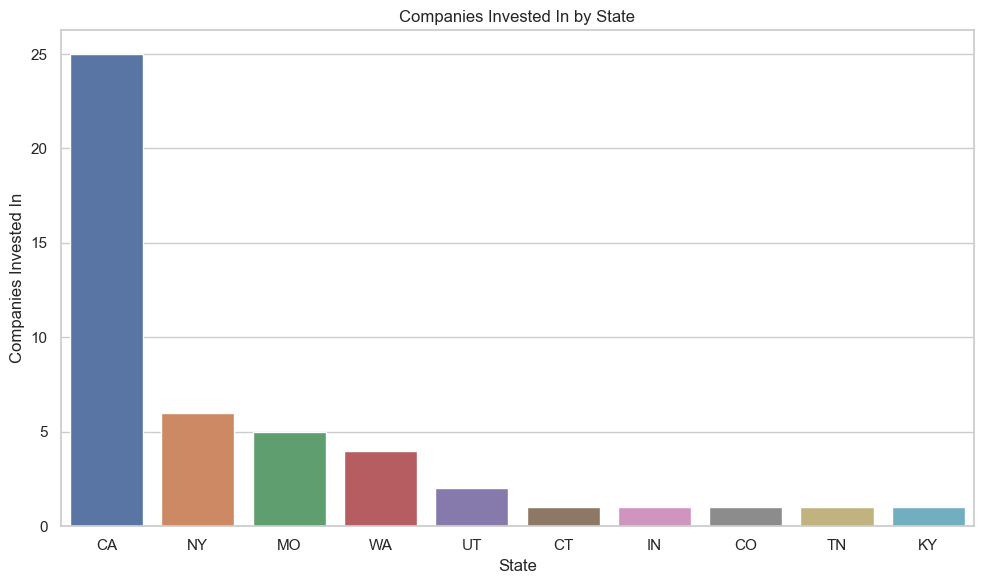

In [ ]:
# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y='count', x='state_code', data=state_investment_info)
plt.xlabel('State')
plt.ylabel('Companies Invested In')
plt.title("Companies Invested In by State")

# Save the figure
plt.savefig('state_investment_count.png')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

In [ ]:
#Creating a funding rounds table that shows what the companies most recent valuation is
funding_rounds1 = funding_rounds[funding_rounds['is_last_round'] == 1]

funding_rounds2 = funding_rounds1[funding_rounds1['post_money_valuation_usd'] > 0]

funding_rounds_comparison = funding_rounds2[['object_id', 'funded_at', 'post_money_valuation_usd']].rename(columns={'post_money_valuation_usd': 'most_recent_valuation'})

In [ ]:
#showing latest_valuation for companies still operating
operating_companies = investments_info[investments_info['status'] == 'operating']

#combing tables to show investments with their most recent valuation
operating_companies_valuation1 = pd.merge(operating_companies, funding_rounds_comparison, left_on = 'funded_object_id', right_on = 'object_id', how = 'inner')

#filtering values
operating_companies_valuation = operating_companies_valuation1[['Fund_name', 'Invested_Company_name','country_code', 'state_code','category_code', 'post_money_valuation', 'most_recent_valuation']].rename(columns={'post_money_valuation': 'valuation_at_investment'})

#creating a fucntion that checks if the current valuation was higher than initial valuation
def was_money_made(row):
    if row['most_recent_valuation'] > row['valuation_at_investment']:
        return 'Money Made'
    if row['most_recent_valuation'] == row['valuation_at_investment']:
        return 'No Change in Valuation'
    else:
        return 'Money Lost'

operating_companies_valuation['Result'] = operating_companies_valuation.apply(was_money_made, axis = 1)

#creating count dataframe that evaluates success rates overall
operating_result_count = operating_companies_valuation['Result'].value_counts().reset_index()

#creating count dataframe that evaluates success rates by category code
category_result_count_ops = operating_companies_valuation.groupby(['category_code', 'Result']).size().reset_index(name='count')

#creating count dataframe that evaluates success rates by country
country_result_count_ops = operating_companies_valuation.groupby(['country_code', 'Result']).size().reset_index(name='count')

#creating count dataframe that evaluates success rates by state
state_result_count_ops = operating_companies_valuation.groupby(['state_code', 'Result']).size().reset_index(name='count')

category_result_count_ops

,category_code,Result,count
0,cleantech,Money Lost,2
1,cleantech,No Change in Valuation,1
2,ecommerce,Money Lost,10
3,ecommerce,No Change in Valuation,37
4,hardware,No Change in Valuation,1
5,mobile,No Change in Valuation,2
6,network_hosting,No Change in Valuation,3
7,software,Money Lost,2
8,software,No Change in Valuation,30
9,web,No Change in Valuation,17


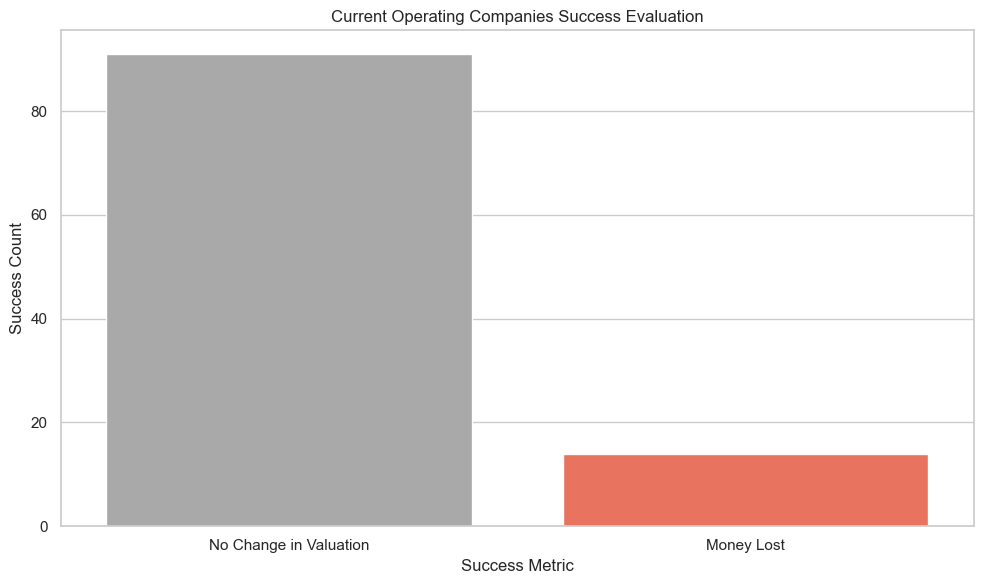

In [ ]:
#plotting overall success rates
colors = ['#A9A9A9', '#FF6347']  # Red for 'Money Lost', Grey for 'No Change in Valuation'
plt.figure(figsize=(10, 6))
sns.barplot(y='count', x='Result', data=operating_result_count, palette=colors)
plt.xlabel('Success Metric')
plt.ylabel('Success Count')
plt.title("Current Operating Companies Success Evaluation")

# Save the figure
plt.savefig('operating_company_success.png')

plt.tight_layout()  # Adjust layout to prevent clipping of labels
plt.show()

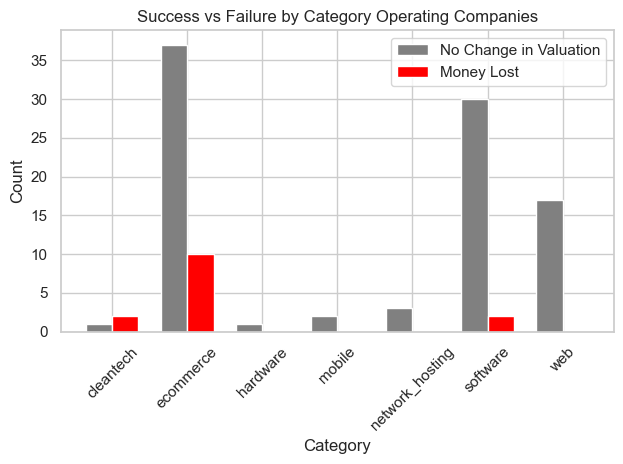

In [ ]:
import matplotlib.pyplot as plt

# Group by category_code and Result, then count occurrences
grouped = category_result_count_ops.groupby(['category_code', 'Result'])['count'].sum().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
x = range(len(grouped))

success_bars = ax.bar(x, grouped['No Change in Valuation'], width, label='No Change in Valuation', color = "grey")
failure_bars = ax.bar([i + width for i in x], grouped['Money Lost'], width, label='Money Lost', color = 'red')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(grouped.index)
ax.legend()

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Success vs Failure by Category Operating Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('operating_company_success_category.png')

plt.show()

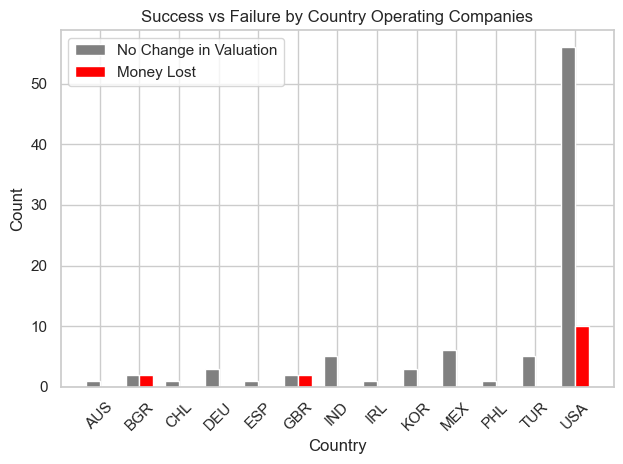

In [ ]:
# Group by category_code and Result, then count occurrences
grouped = country_result_count_ops.groupby(['country_code', 'Result'])['count'].sum().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
x = range(len(grouped))

success_bars = ax.bar(x, grouped['No Change in Valuation'], width, label='No Change in Valuation', color = "grey")
failure_bars = ax.bar([i + width for i in x], grouped['Money Lost'], width, label='Money Lost', color = 'red')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(grouped.index)
ax.legend()

plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Success vs Failure by Country Operating Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('operating_company_success_country.png')

plt.show()

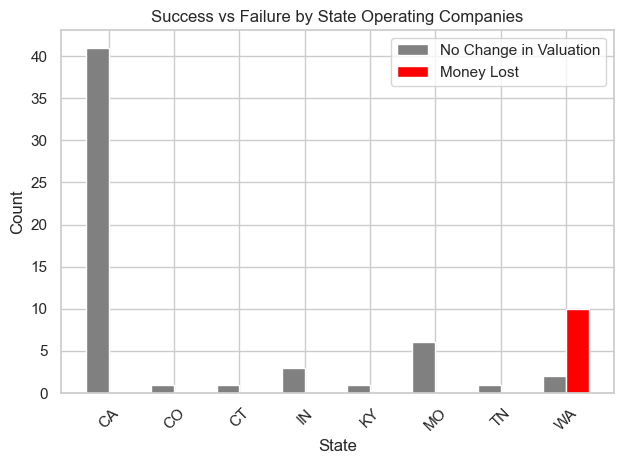

In [ ]:
# Group by category_code and Result, then count occurrences
grouped = state_result_count_ops.groupby(['state_code', 'Result'])['count'].sum().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
x = range(len(grouped))

success_bars = ax.bar(x, grouped['No Change in Valuation'], width, label='No Change in Valuation', color = "grey")
failure_bars = ax.bar([i + width for i in x], grouped['Money Lost'], width, label='Money Lost', color = 'red')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(grouped.index)
ax.legend()

plt.xlabel('State')
plt.ylabel('Count')
plt.title('Success vs Failure by State Operating Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('operating_company_success_state.png')

plt.show()

In [ ]:
#creating a table of all investments that have been acquired
acquired_companies = investments_info[investments_info['status'] == 'acquired']

#combing tables to show investments with their most recent valuation
acquired_companies_valuation1 = pd.merge(acquired_companies, acquisitions, left_on = 'funded_object_id', right_on = 'acquired_object_id', how = 'inner')

#filtering dataframe values
acquired_companies_valuation = acquired_companies_valuation1[['Fund_name', 'Invested_Company_name','country_code', 'state_code','category_code', 'post_money_valuation', 'price_amount']].rename(columns={'price_amount': 'Acquisition_price', 'post_money_valuation': 'valuation_at_investment'})

#creating a fucntion that checks if the acquisition price was higher than initial valuation
def was_money_made(row):
    if row['Acquisition_price'] > row['valuation_at_investment']:
        return 'Money Made'
    if row['Acquisition_price'] == row['valuation_at_investment']:
        return 'No Money Lost or Made'
    else:
        return 'Money Lost'

acquired_companies_valuation['Result'] = acquired_companies_valuation.apply(was_money_made, axis = 1)

#creating count dataframe that evaluates success rates overall
acquired_result_count = acquired_companies_valuation['Result'].value_counts().reset_index()

#creating count dataframe that evaluates success rates by category code
category_result_count_acq = acquired_companies_valuation.groupby(['category_code', 'Result']).size().reset_index(name='count')

#creating count dataframe that evaluates success rates by country
country_result_count_acq = acquired_companies_valuation.groupby(['country_code', 'Result']).size().reset_index(name='count')

#creating count dataframe that evaluates success rates by state
state_result_count_acq = acquired_companies_valuation.groupby(['state_code', 'Result']).size().reset_index(name='count')

category_result_count_acq


,category_code,Result,count
0,ecommerce,Money Made,2
1,mobile,Money Lost,9
2,web,Money Lost,9
3,web,Money Made,24


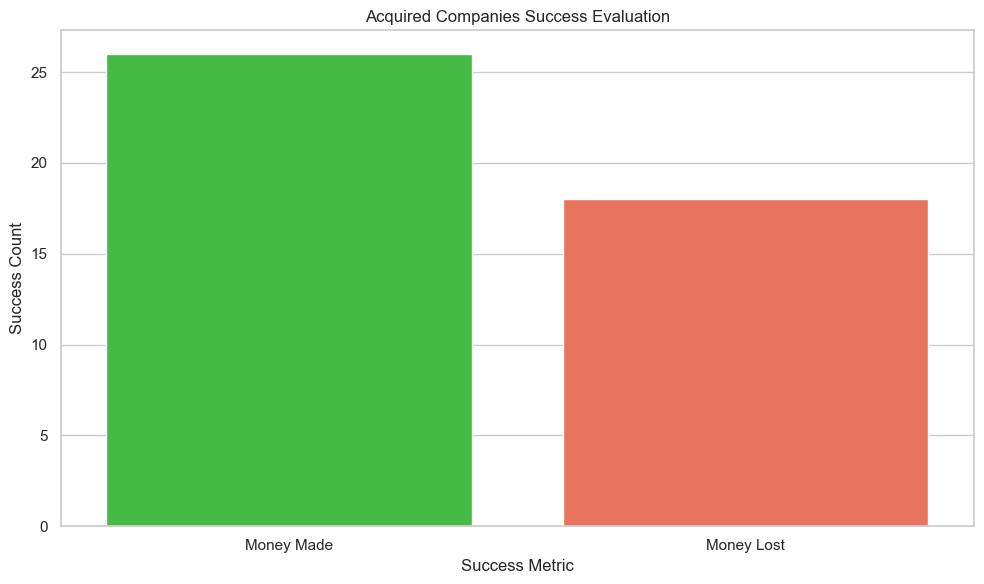

In [ ]:
#plotting overall success rates
colors = ['#32CD32','#FF6347']  # Red for 'Money Lost', Green for 'Money Made'
plt.figure(figsize=(10, 6))
sns.barplot(y='count', x='Result', data=acquired_result_count, palette=colors)
plt.xlabel('Success Metric')
plt.ylabel('Success Count')
plt.title("Acquired Companies Success Evaluation")
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('acquired_company_success.png')

plt.show()

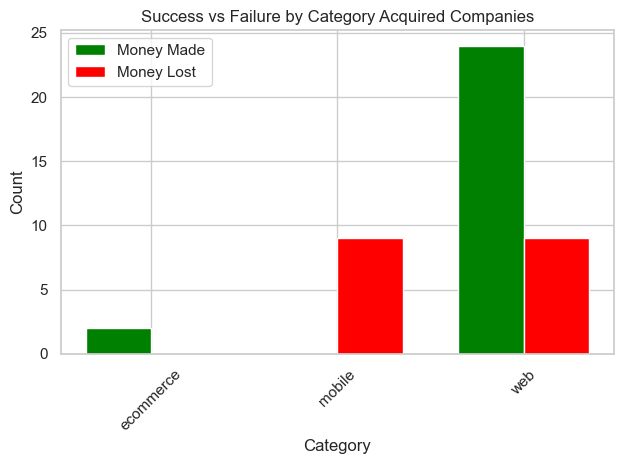

In [ ]:
# Group by category_code and Result, then count occurrences
grouped = category_result_count_acq.groupby(['category_code', 'Result'])['count'].sum().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
x = range(len(grouped))

success_bars = ax.bar(x, grouped['Money Made'], width, label='Money Made', color = "green")
failure_bars = ax.bar([i + width for i in x], grouped['Money Lost'], width, label='Money Lost', color = 'red')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(grouped.index)
ax.legend()

plt.xlabel('Category')
plt.ylabel('Count')
plt.title('Success vs Failure by Category Acquired Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('acquired_company_success_category.png')

plt.show()

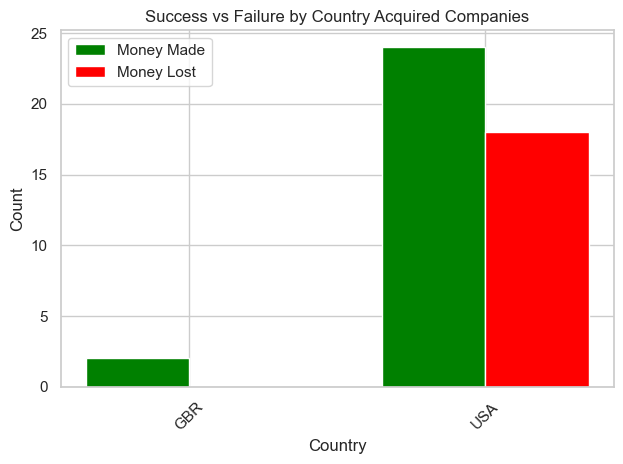

In [ ]:
# Group by country_code and Result, then count occurrences
grouped = country_result_count_acq.groupby(['country_code', 'Result'])['count'].sum().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
x = range(len(grouped))

success_bars = ax.bar(x, grouped['Money Made'], width, label='Money Made', color = "green")
failure_bars = ax.bar([i + width for i in x], grouped['Money Lost'], width, label='Money Lost', color = 'red')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(grouped.index)
ax.legend()

plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Success vs Failure by Country Acquired Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('acquired_company_success_country.png')

plt.show()

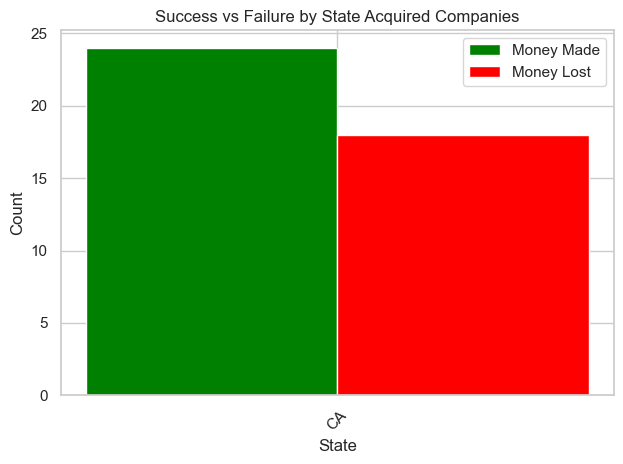

In [ ]:
# Group by state_code and Result, then count occurrences
grouped = state_result_count_acq.groupby(['state_code', 'Result'])['count'].sum().unstack(fill_value=0)

# Plotting
fig, ax = plt.subplots()
width = 0.35  # the width of the bars
x = range(len(grouped))

success_bars = ax.bar(x, grouped['Money Made'], width, label='Money Made', color = "green")
failure_bars = ax.bar([i + width for i in x], grouped['Money Lost'], width, label='Money Lost', color = 'red')

ax.set_xticks([i + width / 2 for i in x])
ax.set_xticklabels(grouped.index)
ax.legend()

plt.xlabel('State')
plt.ylabel('Count')
plt.title('Success vs Failure by State Acquired Companies')
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('acquired_company_success_state.png')

plt.show()

In [ ]:
#creating a table of all investments that have been acquired
acquired_companies = investments_info[investments_info['status'] == 'acquired']

#fund acquired counts
acquired_counts1 = acquired_companies.groupby('Fund_name').count()

acquired_counts = acquired_counts1[['status']].rename(columns = {'status': 'Acquired_Count'})

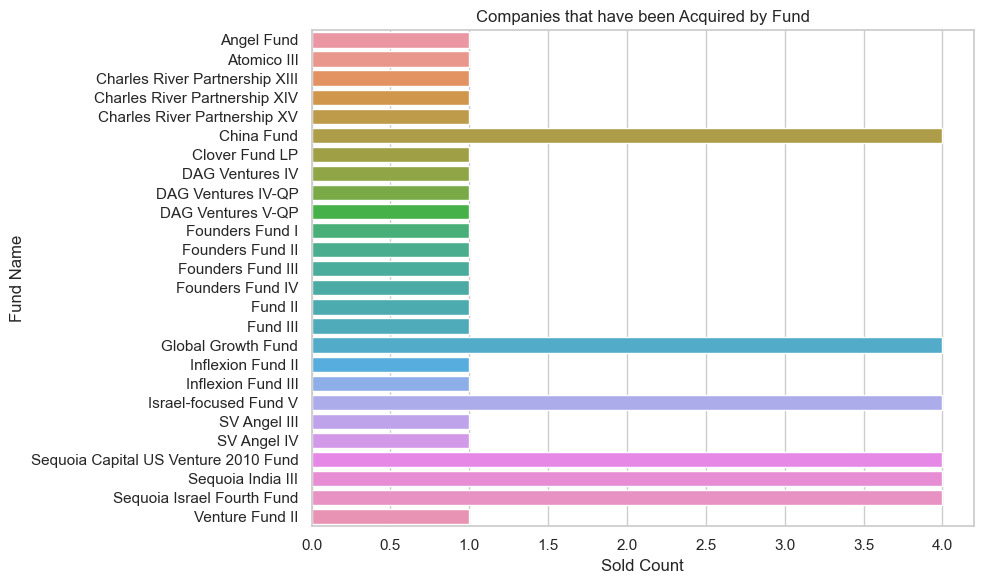

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y=acquired_counts.index, x='Acquired_Count', data=acquired_counts)
plt.xlabel('Sold Count')
plt.ylabel('Fund Name')
plt.title('Companies that have been Acquired by Fund')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('acquired_companies_by_fund.png')

plt.show()

In [ ]:
#creating a table of all investments that are still operating
operating_companies = investments_info[investments_info['status'] == 'operating']

#fund operating counts
operating_counts1 = operating_companies.groupby('Fund_name').count()

operating_counts2 = operating_counts1[['status']].rename(columns = {'status': 'Operating_Count'})

#filtering to only show relevant data and not have the visualization drowned out by funds with 1 or 2
operating_counts = operating_counts2[operating_counts2['Operating_Count'] > 2]

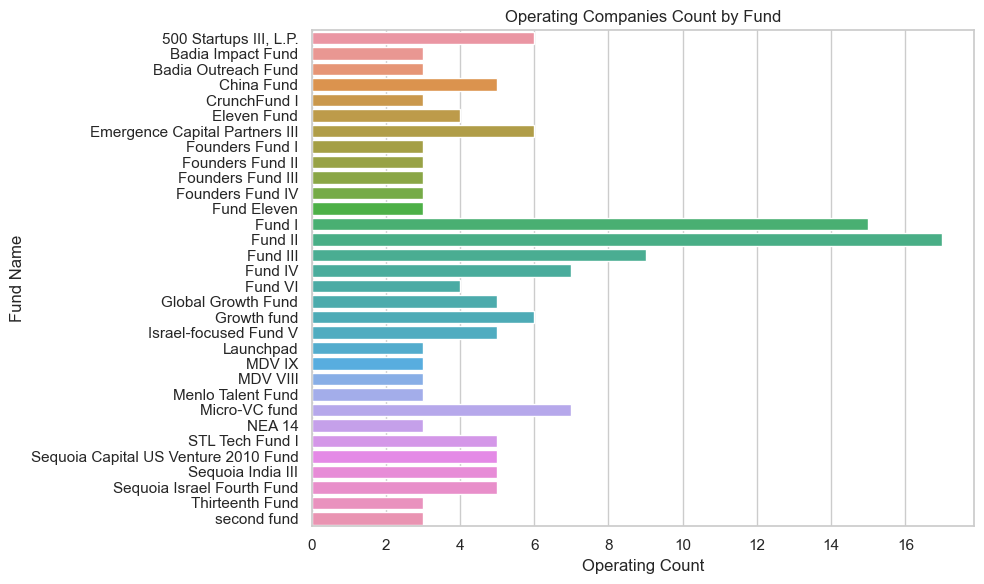

In [ ]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plotting
plt.figure(figsize=(10, 6))
sns.barplot(y=operating_counts.index, x='Operating_Count', data=operating_counts)
plt.xlabel('Operating Count')
plt.ylabel('Fund Name')
plt.title('Operating Companies Count by Fund')
plt.tight_layout()  # Adjust layout to prevent clipping of labels

# Save the figure
plt.savefig('operating_companies_by_fund.png')

In [ ]:
from IPython.display import display, HTML

# Function to display an image with HTML
def display_image_html(filename, width='auto', height='auto'):
    return f'<img src="{filename}" style="width: {width}; height: {height}; margin: 5px;"/>'

# List of PNG filenames
png_files = ['operating_companies_by_fund.png', 'acquired_companies_by_fund.png', 'acquired_company_success_state.png', 'acquired_company_success_country.png', 'acquired_company_success_category.png', 'acquired_company_success.png','operating_company_success_state.png', 'operating_company_success_country.png', 'operating_company_success_category.png', 'operating_company_success.png', 'state_investment_count.png', 'country_investment_count.png', 'category_investment_count.png']

# Combine images into a single HTML string
images_html = ''.join([display_image_html(filename, width='200px', height='auto') for filename in png_files])

# Display HTML with custom grid layout
html_content = (f'''
<div style="display: grid; grid-template-columns: 400px repeat(2, 400px); grid-template-rows: auto auto auto; gap: 10px; background-color: #8FA173; padding: 10px; border: 1px solid black;"">
    <h1 style="text-align: center;">Private Investment Activity and Success in the Tech Space</h1>
    {display_image_html(png_files[0], width='400px', height='auto')}
    {display_image_html(png_files[1], width='400px', height='auto')}
    <div style="visibility: hidden;"></div>
    {display_image_html(png_files[9], width= '400px', height='auto')}
    {display_image_html(png_files[5], width='400px', height='auto')}
    {display_image_html(png_files[12], width='400px', height='300px')}
    {display_image_html(png_files[8], width='400px', height='auto')}
    {display_image_html(png_files[4], width='400px', height='auto')}
    {display_image_html(png_files[11], width='400px', height='300px')}
    {display_image_html(png_files[7], width='400px', height='auto')}
    {display_image_html(png_files[3], width='400px', height='auto')}
    {display_image_html(png_files[10], width='400px', height='300px')}
    {display_image_html(png_files[6], width='400px', height='auto')}
    {display_image_html(png_files[2], width='400px', height='auto')}
</div>
''')

# Save HTML content to a file
with open('display.html', 'w') as file:
    file.write(html_content)
